In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0
torch:  2.0 ; cuda:  cu117
detectron2: 0.6


In [2]:
import os
import sys
import logging
import argparse
os.environ["DATASET"] = "../datasets"

pth = '/'.join(sys.path[0].split('/')[:-1])
sys.path.insert(0, pth)

from pprint import pprint
import numpy as np
np.random.seed(1)

home_dir = os.path.abspath(os.getcwd()+"/../")
sys.path.append(home_dir)
print(home_dir)

import warnings
warnings.filterwarnings(action='ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from hdecoder.BaseModel import BaseModel
from hdecoder import build_model
from utils.distributed import init_distributed
from utils.arguments import load_opt_from_config_files, load_config_dict_to_opt

/home/djjin/Mygit/X-Decoder


Invalid MIT-MAGIC-COOKIE-1 key

In [3]:
from utils.arguments import load_vcoco_opt_command, load_vcoco_parser

cmdline_args = load_vcoco_parser()
cmdline_args.conf_files = [os.path.join(home_dir, "configs/hdecoder/vcoco.yaml")]
# cmdline_args.overrides = ['WEIGHT', 'true', 'RESUME_FROM', '../checkpoints/xdecoder_focalt_best_openseg.pt'] 
cmdline_args.overrides = ['DONT_LOAD_MODEL', 'false', 'PYLEARN_MODEL', '../data/output/test/00062100/default/raw_model_states.pt'] 

opt = load_vcoco_opt_command(cmdline_args)
opt["WEIGHT"]
opt = init_distributed(opt)

In [4]:
opt['VCOCO']['TEST']['BATCH_SIZE_TOTAL'] = 1

In [5]:
from datasets.build import build_eval_dataloader
test_data_loader = build_eval_dataloader(opt)
dataset_names = opt['DATASETS']['TEST']

INFO:detectron2.data.common:Serializing 4946 elements to byte tensors and concatenating them all ...
INFO:detectron2.data.common:Serialized dataset takes 3.27 MiB


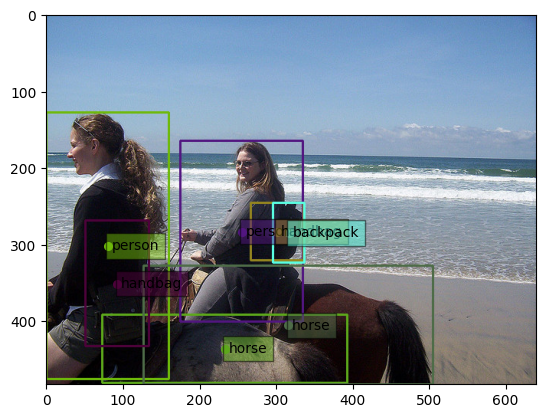

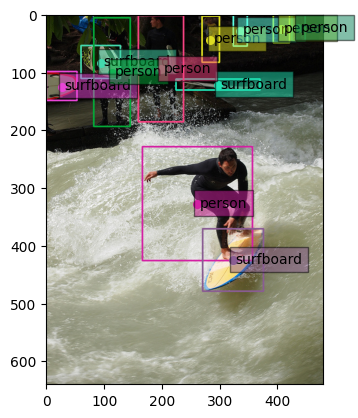

In [6]:
import cv2, random
import numpy as np
from PIL import Image
from datasets.utils.vcoco_utils import valid_obj_ids, get_coco_instance_ID_to_name
from matplotlib import pyplot as plt

def random_color():
    rdn = random.randint(1, 1000)
    b = int(rdn * 997) % 255
    g = int(rdn * 4447) % 255
    r = int(rdn * 6563) % 255
    return b, g, r


for dataloader, dataset_name in zip(test_data_loader, dataset_names):
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            if idx >= 2:
                break
            for test in batch:
                target_img = test["image"]
                target = test["instances"]
                img = Image.open(test["instances"]["filename"]).convert('RGB')
                img = np.asarray(img)

                obj_labels = []
                labels = []
                verb_names = []
                ob_boxes = []
                sub_boxes = []

                obj_boxes = target['boxes'].cpu().numpy()

                for idx in target['labels']:
                    label_name = get_coco_instance_ID_to_name(valid_obj_ids[idx])
                    labels.append(label_name)
                for label, box in zip(labels, obj_boxes):
                    color = random_color()
                    box = box.astype(int)
                    x1, y1, x2, y2 = box
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                    x = (x1 + x2) / 2
                    y = (y1 + y2) / 2

                    plt.scatter(x, y, 30, color=[i/255 for i in color])
                    plt.text(
                        x + 5,
                        y + 5,
                        label,
                        fontsize=10,
                        bbox=dict(facecolor=[i/255 for i in color], alpha=0.5),
                        )

                plt.imshow(img)
                plt.show()
                